In [277]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning import LightningModule
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from skimage import io
from glob import glob
from imgaug import augmenters as iaa
import os

## HPs

In [278]:
SAVE_PATH = "./datasets/"
BATCH_SIZE = 1 
EPOCHS = 200 
MAX_SANITY_STEPS = 2

A_transforms = A.Compose([
    A.Resize(height=256, width=256),
    A.ToGray(always_apply=True, p=1),
    ToTensorV2()
])

In [279]:

class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None, additional_transforms=False):
        super().__init__()
        self.image_dir = image_dir
        self.images_list = glob(self.image_dir + "/*")
        self.transform = transform
        self.additional_transforms = additional_transforms

    def __len__(self):
        return len(self.images_list)
        
    def __getitem__(self, index):
        img_name = self.images_list[index]
        image = io.imread(img_name)
        noisy_image = image

        if(self.additional_transforms):
            iaa_transforms = iaa.Sequential([iaa.SaltAndPepper(0.3)])
            noisy_image = iaa_transforms.augment_image(image=noisy_image)     

        image = self.transform(image=image) 
        noisy_image = self.transform(image=noisy_image) 
        return {"Noisy": noisy_image, "Original": image}

In [280]:
train_ds_noised = ImageDataset(image_dir="./images/", transform=A_transforms, additional_transforms=True)
print(f"Length of noised train dataset: {train_ds_noised.__len__()}")


Length of noised train dataset: 8


<h2>Show Initial Image</h2>

Image shape at index: 0 is torch.Size([3, 256, 256])
Image shape at index: 1 is torch.Size([3, 256, 256])
Image shape at index: 2 is torch.Size([3, 256, 256])
Image shape at index: 3 is torch.Size([3, 256, 256])
Image shape at index: 4 is torch.Size([3, 256, 256])
Image shape at index: 5 is torch.Size([3, 256, 256])
Image shape at index: 6 is torch.Size([3, 256, 256])
Image shape at index: 7 is torch.Size([3, 256, 256])


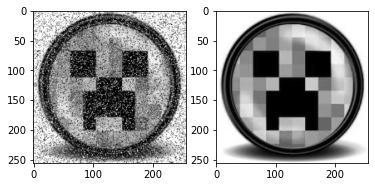

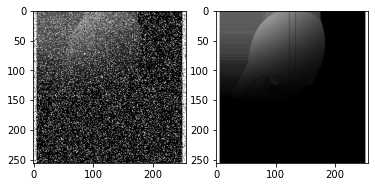

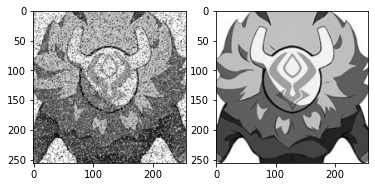

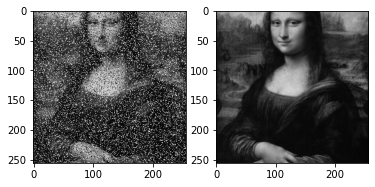

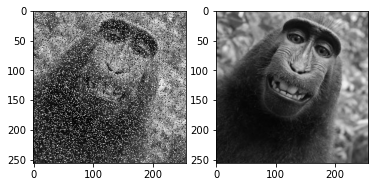

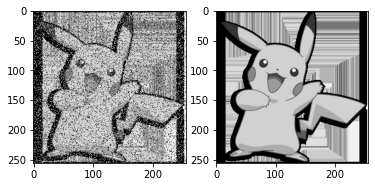

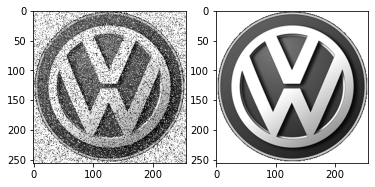

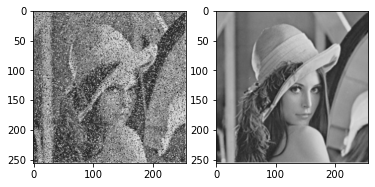

<Figure size 432x288 with 0 Axes>

In [281]:
for i in range(train_ds_noised.__len__()):
    print(f"Image shape at index: {i} is {train_ds_noised.__getitem__(i)['Noisy']['image'].shape}")
    plt.title(f"Figure #{i}")
    plt.subplot(121)
    plt.imshow(train_ds_noised.__getitem__(i)['Noisy']['image'].permute(1, 2, 0))
    plt.subplot(122)
    plt.imshow(train_ds_noised.__getitem__(i)['Original']['image'].permute(1, 2, 0))
    plt.figure()

In [282]:
train_loader_noised = DataLoader(train_ds_noised, batch_size=BATCH_SIZE)
print(len(train_loader_noised))

8


## Custom Autoencoder model

In [291]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
    def forward(self, x):
        return self.l1(x)
    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.UpsamplingNearest2d(scale_factor=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.UpsamplingNearest2d(scale_factor=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.UpsamplingNearest2d(scale_factor=2),

            nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, padding='same'),
            nn.UpsamplingNearest2d(scale_factor=2),
        )
    def forward(self, x):
        return self.l1(x)

## ImageAutoEncodingModule

In [302]:
class ImageAutoEncodingModule(LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder 
    
    def training_step(self, batch, batch_idx):
        x_noise = batch['Noisy']['image'].float()
        x_target = batch['Original']['image'].float()

        x_1 = self.encoder(x_noise)
        x_pred = self.decoder(x_1)
        
        #print("Noisy in", x_noise.shape)
        #print("Original in", x_target.shape)
        #print("Pred out", x_pred.shape)

        loss = F.mse_loss(x_pred, x_target)
        return loss
    
    def test_step(self, batch, batch_idx):
        x_noise = batch['Noisy']['image'].float()
        x_target = batch['Original']['image'].float()

        x_1 = self.encoder(x_noise)
        x_pred = self.decoder(x_1)

        loss = F.mse_loss(x_pred, x_target)
        self.log("test_loss", loss)
        
        x_pred = x_pred.cpu()
        x_target = x_target.cpu()
        
        plt.title(f"Figure #{batch_idx}")
        plt.subplot(121)
        plt.title("Target image")
        plt.imshow(x_target[0].permute(1, 2, 0))
        plt.subplot(122)
        plt.title("Predicted image")
        plt.imshow(x_pred[0].permute(1, 2, 0))
        plt.figure()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

## Training

In [303]:
IS_TRAINING = False

autoencoder = ImageAutoEncodingModule(Encoder(), Decoder())
trainer = Trainer(accelerator="auto", devices=1 if torch.cuda.is_available() else None, max_epochs=EPOCHS, num_sanity_val_steps=MAX_SANITY_STEPS)
if(IS_TRAINING):
    trainer.fit(model=autoencoder, train_dataloaders=train_loader_noised)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


<h2>Testing</h2>

Restoring states from the checkpoint path at ./lightning_logs/version_7/checkpoints/epoch=199-step=1600.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./lightning_logs/version_7/checkpoints/epoch=199-step=1600.ckpt
c:\Users\steve\anaconda3\envs\pytorchMain\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:219: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    1184.8748779296875     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1184.8748779296875}]

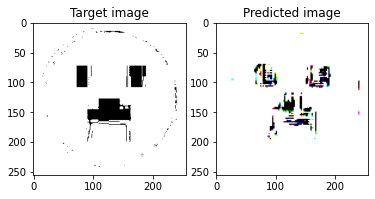

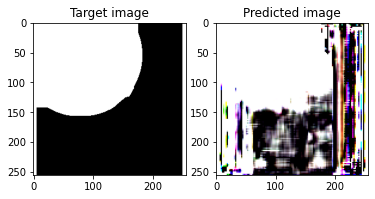

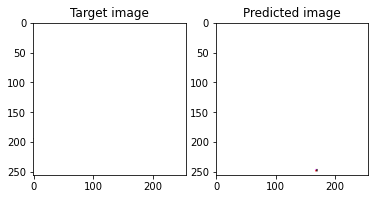

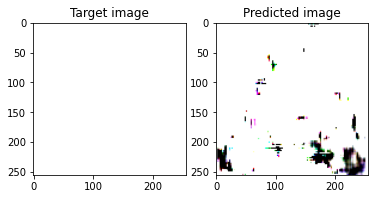

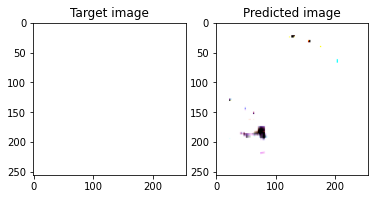

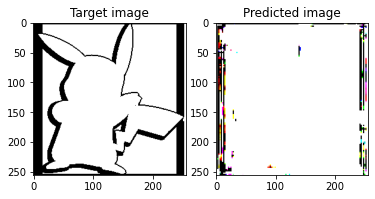

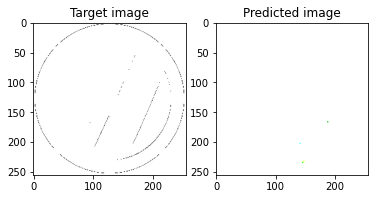

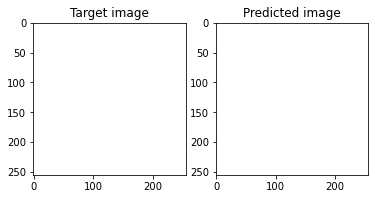

<Figure size 432x288 with 0 Axes>

In [304]:
trainer.test(model=autoencoder, ckpt_path="./lightning_logs/version_7/checkpoints/epoch=199-step=1600.ckpt", dataloaders=train_loader_noised)